In [1]:
from pconv_unet import PartialConvUNet
import torch


In [2]:
def get_device():
    """Get the device to use for PyTorch operations (CPU or cuda or MPS)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using CUDA


In [3]:
model = PartialConvUNet().to(device)


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.ShiftScaleRotate(p=0.2),
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
from datamodule import InpaintingDataset

ds = InpaintingDataset(
    images_dir='../image_generation/generated/backgrounds/',
    masks_dir='../image_generation/generated/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
)

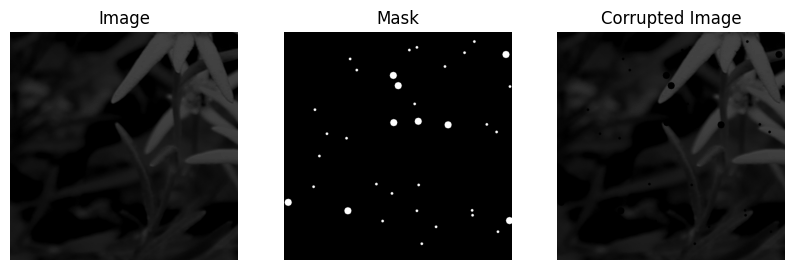

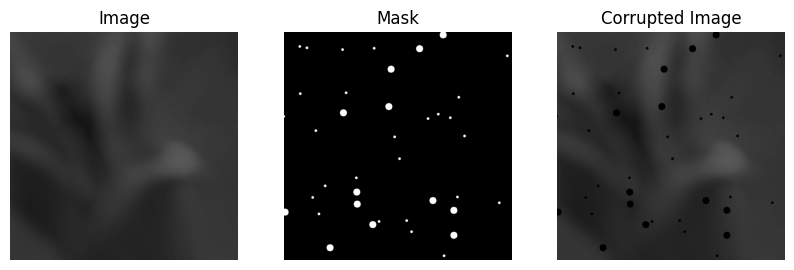

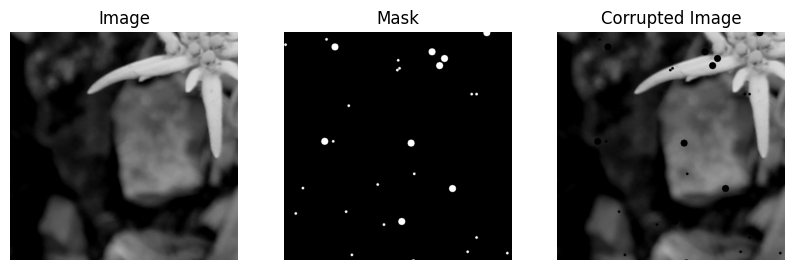

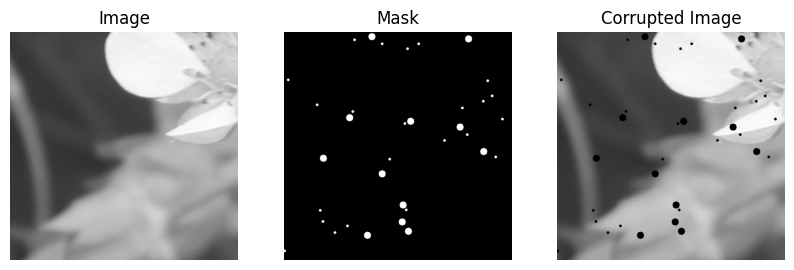

In [9]:
import matplotlib.pyplot as plt
for im, mask in ds:
    cor = im * (1 - mask)
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Mask')
    axs[2].imshow(cor.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[2].set_title('Corrupted Image')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [10]:
from datamodule import InpaintingDataModule
dm = InpaintingDataModule(
    train_images_dir='../image_generation/generated/backgrounds/',
    train_masks_dir='../image_generation/generated/masks/',
    val_images_dir='../image_generation/generated/backgrounds/',
    val_masks_dir='../image_generation/generated/masks/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(512, 512),
    batch_size=2,
    num_workers=0,      # SE aumento il numero di workers, va molto più lento
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [11]:
for images, masks in train_loader:
    print(images.shape)  
    print(masks.shape)   
    

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])


In [12]:
model = PartialConvUNet().to(device)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2


In [18]:

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for original, mask in progress_bar:
        original = original.to(device)
        mask = mask.to(device)
        corrupted = original * (1 - mask)
        # Forward pass
        optimizer.zero_grad()
        output = model(corrupted, mask)
        print(torch.max(output))
        
        # Calculate loss (only for the masked regions)
        masked_diff = (output - original) * mask
        loss = (masked_diff ** 2).sum() / mask.sum()

        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1067]

tensor(0.6246, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1/300: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s, loss=0.0362]


tensor(0.5957, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1/300, Loss: 0.0714


Epoch 2/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.1305]

tensor(0.5998, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0496]


tensor(0.6138, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2/300, Loss: 0.0900


Epoch 3/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0989]

tensor(0.6016, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0313]


tensor(0.7334, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3/300, Loss: 0.0651


Epoch 4/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0319]

tensor(0.6165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4/300: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s, loss=0.0530]


tensor(0.5991, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4/300, Loss: 0.0425


Epoch 5/300:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0080]

tensor(0.6519, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0801]


tensor(0.9159, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5/300, Loss: 0.0440


Epoch 6/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0621]

tensor(0.7084, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0447]


tensor(0.6544, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6/300, Loss: 0.0534


Epoch 7/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0964]

tensor(0.5876, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7/300:  50%|█████     | 1/2 [00:01<00:00,  1.48it/s, loss=0.0492]

tensor(0.6519, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0492]


Epoch 7/300, Loss: 0.0728


Epoch 8/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.1062]

tensor(0.5859, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0558]


tensor(0.6020, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8/300, Loss: 0.0810


Epoch 9/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0340]

tensor(0.7256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0406]


tensor(0.6009, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9/300, Loss: 0.0373


Epoch 10/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0710]

tensor(0.9288, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0401]


tensor(0.7303, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10/300, Loss: 0.0556


Epoch 11/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0772]

tensor(0.5772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0211]


tensor(0.5744, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11/300, Loss: 0.0492


Epoch 12/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0407]

tensor(0.8685, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0865]


tensor(0.5886, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12/300, Loss: 0.0636


Epoch 13/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0620]

tensor(0.8143, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 13/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0427]


tensor(0.5669, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 13/300, Loss: 0.0523


Epoch 14/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0571]

tensor(0.6102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 14/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0392]


tensor(0.8148, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 14/300, Loss: 0.0482


Epoch 15/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0399]

tensor(0.5631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 15/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0606]


tensor(0.7251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 15/300, Loss: 0.0503


Epoch 16/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0631]

tensor(0.6057, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 16/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0546]


tensor(0.6767, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 16/300, Loss: 0.0589


Epoch 17/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0982]

tensor(0.5894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 17/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0244]


tensor(0.7943, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 17/300, Loss: 0.0613


Epoch 18/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0795]

tensor(0.7857, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 18/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0772]

tensor(0.5831, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 18/300, Loss: 0.0783



Epoch 19/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0491]

tensor(0.5826, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 19/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0905]


tensor(0.5595, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 19/300, Loss: 0.0698


Epoch 20/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0768]

tensor(0.5739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 20/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0544]

tensor(0.7343, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 20/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0544]


Epoch 20/300, Loss: 0.0656


Epoch 21/300:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.0546]

tensor(0.5545, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 21/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0345]


tensor(0.5600, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 21/300, Loss: 0.0446


Epoch 22/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0538]

tensor(0.5961, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 22/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0974]


tensor(0.8942, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 22/300, Loss: 0.0756


Epoch 23/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0761]

tensor(0.6687, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 23/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0665]


tensor(0.5947, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 23/300, Loss: 0.0713


Epoch 24/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0934]

tensor(0.5724, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 24/300:  50%|█████     | 1/2 [00:01<00:00,  1.47it/s, loss=0.0706]

tensor(0.7454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 24/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.0706]


Epoch 24/300, Loss: 0.0820


Epoch 25/300:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0481]

tensor(0.5857, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 25/300:  50%|█████     | 1/2 [00:01<00:00,  1.43it/s, loss=0.0828]

tensor(0.5510, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 25/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0828]


Epoch 25/300, Loss: 0.0655


Epoch 26/300:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0841]

tensor(0.5624, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 26/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0770]


tensor(0.6093, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 26/300, Loss: 0.0805


Epoch 27/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.1022]

tensor(0.7220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 27/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0126]

tensor(0.5807, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 27/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0126]


Epoch 27/300, Loss: 0.0574


Epoch 28/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.1056]

tensor(0.5797, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 28/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0399]


tensor(0.6614, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 28/300, Loss: 0.0727


Epoch 29/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0914]

tensor(0.5669, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 29/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0377]


tensor(0.7498, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 29/300, Loss: 0.0646


Epoch 30/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0664]

tensor(0.7982, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 30/300:  50%|█████     | 1/2 [00:01<00:00,  1.48it/s, loss=0.0730]

tensor(0.5572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 30/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0730]


Epoch 30/300, Loss: 0.0697


Epoch 31/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0550]

tensor(0.7218, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 31/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0954]


tensor(0.5567, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 31/300, Loss: 0.0752


Epoch 32/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0823]

tensor(0.5437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 32/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0489]


tensor(0.7185, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 32/300, Loss: 0.0656


Epoch 33/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0890]

tensor(0.6903, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 33/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0333]

tensor(0.5435, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 33/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0333]


Epoch 33/300, Loss: 0.0612


Epoch 34/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0410]

tensor(0.6621, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 34/300: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s, loss=0.0309]


tensor(0.6951, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 34/300, Loss: 0.0360


Epoch 35/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0969]

tensor(0.8967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 35/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0170]


tensor(0.5532, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 35/300, Loss: 0.0569


Epoch 36/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1396]

tensor(0.5423, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 36/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0746]


tensor(0.5421, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 36/300, Loss: 0.1071


Epoch 37/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0661]

tensor(0.6812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 37/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0654]


tensor(0.5428, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 37/300, Loss: 0.0657


Epoch 38/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0536]

tensor(0.8898, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 38/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0269]

tensor(0.5492, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 38/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0269]


Epoch 38/300, Loss: 0.0402


Epoch 39/300:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.1036]

tensor(0.5554, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 39/300:  50%|█████     | 1/2 [00:01<00:00,  1.51it/s, loss=0.1030]

tensor(0.5891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 39/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.1030]


Epoch 39/300, Loss: 0.1033


Epoch 40/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0364]

tensor(0.5366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 40/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0878]


tensor(0.5439, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 40/300, Loss: 0.0621


Epoch 41/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0580]

tensor(0.5856, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 41/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0426]


tensor(0.8279, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 41/300, Loss: 0.0503


Epoch 42/300:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s, loss=0.0832]

tensor(0.5665, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 42/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0520]


tensor(0.5637, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 42/300, Loss: 0.0676


Epoch 43/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0671]

tensor(0.5636, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 43/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0423]


tensor(0.6657, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 43/300, Loss: 0.0547


Epoch 44/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0326]

tensor(0.7969, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 44/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0726]


tensor(0.5997, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 44/300, Loss: 0.0526


Epoch 45/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0535]

tensor(0.6050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 45/300: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s, loss=0.0409]


tensor(0.9274, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 45/300, Loss: 0.0472


Epoch 46/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.1392]

tensor(0.6639, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 46/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0466]


tensor(0.6670, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 46/300, Loss: 0.0929


Epoch 47/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0395]

tensor(0.5970, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 47/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0744]


tensor(0.6094, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 47/300, Loss: 0.0570


Epoch 48/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0945]

tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 48/300: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0762]


tensor(0.5539, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 48/300, Loss: 0.0853


Epoch 49/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0393]

tensor(0.6345, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 49/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0506]


tensor(0.7404, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 49/300, Loss: 0.0450


Epoch 50/300:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0865]

tensor(0.5976, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 50/300:  50%|█████     | 1/2 [00:01<00:00,  1.52it/s, loss=0.1393]

tensor(0.6166, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 50/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.1393]


Epoch 50/300, Loss: 0.1129


Epoch 51/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0337]

tensor(0.5735, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 51/300:  50%|█████     | 1/2 [00:01<00:00,  1.48it/s, loss=0.0720]

tensor(0.5917, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 51/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0720]


Epoch 51/300, Loss: 0.0528


Epoch 52/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0459]

tensor(0.6301, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 52/300: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0519]

tensor(0.7312, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 52/300, Loss: 0.0489


Epoch 53/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0428]

tensor(0.5779, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 53/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0482]


tensor(0.7921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 53/300, Loss: 0.0455


Epoch 54/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0564]

tensor(0.6845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 54/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0373]


tensor(0.6304, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 54/300, Loss: 0.0469


Epoch 55/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.1236]

tensor(0.8706, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 55/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0427]


tensor(0.5713, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 55/300, Loss: 0.0831


Epoch 56/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0855]

tensor(0.5740, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 56/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0619]

tensor(0.6235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 56/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0619]


Epoch 56/300, Loss: 0.0737


Epoch 57/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0766]

tensor(0.5964, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 57/300:  50%|█████     | 1/2 [00:01<00:00,  1.56it/s, loss=0.0758]

tensor(0.5919, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 57/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0758]


Epoch 57/300, Loss: 0.0762


Epoch 58/300:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.0432]

tensor(0.5851, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 58/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0786]


tensor(0.5516, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 58/300, Loss: 0.0609


Epoch 59/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0386]

tensor(0.6850, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 59/300:  50%|█████     | 1/2 [00:01<00:00,  1.55it/s, loss=0.0845]

tensor(0.5981, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 59/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0845]


Epoch 59/300, Loss: 0.0615


Epoch 60/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0498]

tensor(0.8108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 60/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0364]


tensor(0.8225, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 60/300, Loss: 0.0431


Epoch 61/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0447]

tensor(0.8339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 61/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0448]

tensor(0.8265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 61/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0448]


Epoch 61/300, Loss: 0.0447


Epoch 62/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0892]

tensor(0.7187, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 62/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0270]


tensor(0.7677, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 62/300, Loss: 0.0581


Epoch 63/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0659]

tensor(0.5601, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 63/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.1502]


tensor(0.7742, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 63/300, Loss: 0.1081


Epoch 64/300:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.0527]

tensor(0.5897, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 64/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.0716]

tensor(0.5549, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 64/300, Loss: 0.0621



Epoch 65/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0473]

tensor(0.6373, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 65/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0621]

tensor(0.7045, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 65/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0621]


Epoch 65/300, Loss: 0.0547


Epoch 66/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1169]

tensor(0.5461, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 66/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0395]

tensor(0.5484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 66/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0395]


Epoch 66/300, Loss: 0.0782


Epoch 67/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0773]

tensor(0.5633, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 67/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0513]


tensor(0.5510, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 67/300, Loss: 0.0643


Epoch 68/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0607]

tensor(0.6289, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 68/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0531]


tensor(0.6048, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 68/300, Loss: 0.0569


Epoch 69/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0546]

tensor(0.7534, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 69/300:  50%|█████     | 1/2 [00:01<00:00,  1.54it/s, loss=0.0702]

tensor(0.6558, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 69/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0702]


Epoch 69/300, Loss: 0.0624


Epoch 70/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.1121]

tensor(0.5427, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 70/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0466]


tensor(0.6906, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 70/300, Loss: 0.0793


Epoch 71/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.1053]

tensor(0.6447, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 71/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0275]


tensor(0.6008, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 71/300, Loss: 0.0664


Epoch 72/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0335]

tensor(0.7390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 72/300:  50%|█████     | 1/2 [00:01<00:00,  1.49it/s, loss=0.0316]

tensor(0.5582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 72/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0316]


Epoch 72/300, Loss: 0.0326


Epoch 73/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0815]

tensor(0.6231, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 73/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0237]


tensor(0.5773, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 73/300, Loss: 0.0526


Epoch 74/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0731]

tensor(0.6845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 74/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0915]

tensor(0.9018, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 74/300, Loss: 0.0823


Epoch 75/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0489]

tensor(0.6023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 75/300:  50%|█████     | 1/2 [00:01<00:00,  1.46it/s, loss=0.0541]

tensor(0.7561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 75/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0541]


Epoch 75/300, Loss: 0.0515


Epoch 76/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0744]

tensor(0.5650, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 76/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0385]


tensor(0.5957, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 76/300, Loss: 0.0564


Epoch 77/300:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0566]

tensor(0.5684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 77/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0447]


tensor(0.5757, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 77/300, Loss: 0.0506


Epoch 78/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0396]

tensor(0.5893, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 78/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.1130]

tensor(0.5847, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 78/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.1130]


Epoch 78/300, Loss: 0.0763


Epoch 79/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0673]

tensor(0.5941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 79/300:  50%|█████     | 1/2 [00:01<00:00,  1.44it/s, loss=0.0344]

tensor(0.7921, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 79/300: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0344]


Epoch 79/300, Loss: 0.0508


Epoch 80/300:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0316]

tensor(0.6140, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 80/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0501]


tensor(0.5766, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 80/300, Loss: 0.0408


Epoch 81/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0814]

tensor(0.5694, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 81/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0433]

tensor(0.8064, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 81/300, Loss: 0.0623


Epoch 82/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0490]

tensor(0.6221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 82/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0557]


tensor(0.7834, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 82/300, Loss: 0.0523


Epoch 83/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0458]

tensor(0.5947, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 83/300:  50%|█████     | 1/2 [00:01<00:00,  1.46it/s, loss=0.0331]

tensor(0.5855, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 83/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0331]


Epoch 83/300, Loss: 0.0394


Epoch 84/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0670]

tensor(0.6080, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 84/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0394]


tensor(0.6089, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 84/300, Loss: 0.0532


Epoch 85/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0806]

tensor(0.8273, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 85/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.1259]

tensor(0.5974, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 85/300, Loss: 0.1032



Epoch 86/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0280]

tensor(0.5924, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 86/300:  50%|█████     | 1/2 [00:01<00:00,  1.55it/s, loss=0.0294]

tensor(0.7409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 86/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0294]


Epoch 86/300, Loss: 0.0287


Epoch 87/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0496]

tensor(0.6221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 87/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0200]


tensor(0.7683, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 87/300, Loss: 0.0348


Epoch 88/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0349]

tensor(0.5935, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 88/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0859]


tensor(0.6328, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 88/300, Loss: 0.0604


Epoch 89/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0681]

tensor(0.6801, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 89/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0978]


tensor(0.5448, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 89/300, Loss: 0.0830


Epoch 90/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1026]

tensor(0.5429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 90/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0307]


tensor(0.5782, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 90/300, Loss: 0.0666


Epoch 91/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0742]

tensor(0.5631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 91/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0301]


tensor(0.5552, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 91/300, Loss: 0.0522


Epoch 92/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0769]

tensor(0.5872, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 92/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0435]


tensor(0.5629, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 92/300, Loss: 0.0602


Epoch 93/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0456]

tensor(0.6124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 93/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0718]


tensor(0.5745, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 93/300, Loss: 0.0587


Epoch 94/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0684]

tensor(0.5629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 94/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0580]


tensor(0.6695, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 94/300, Loss: 0.0632


Epoch 95/300:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=0.0346]

tensor(0.5492, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 95/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0866]


tensor(0.7818, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 95/300, Loss: 0.0606


Epoch 96/300:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0605]

tensor(0.5915, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 96/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0640]


tensor(0.8188, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 96/300, Loss: 0.0623


Epoch 97/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1261]

tensor(0.7131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 97/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0542]


tensor(0.5777, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 97/300, Loss: 0.0902


Epoch 98/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0824]

tensor(0.7283, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 98/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0511]

tensor(0.7445, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 98/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0511]


Epoch 98/300, Loss: 0.0667


Epoch 99/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0397]

tensor(0.5661, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 99/300:  50%|█████     | 1/2 [00:01<00:00,  1.44it/s, loss=0.0541]

tensor(0.5680, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 99/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0541]


Epoch 99/300, Loss: 0.0469


Epoch 100/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0667]

tensor(0.5718, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 100/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0554]


tensor(0.5694, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 100/300, Loss: 0.0610


Epoch 101/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0775]

tensor(0.6012, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 101/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0707]


tensor(0.5584, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 101/300, Loss: 0.0741


Epoch 102/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0769]

tensor(0.6294, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 102/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0553]


tensor(0.7101, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 102/300, Loss: 0.0661


Epoch 103/300:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0456]

tensor(0.5696, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 103/300:  50%|█████     | 1/2 [00:01<00:00,  1.40it/s, loss=0.0443]

tensor(0.5490, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 103/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0443]


Epoch 103/300, Loss: 0.0450


Epoch 104/300:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0343]

tensor(0.8339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 104/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0434]

tensor(0.5560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 104/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0434]


Epoch 104/300, Loss: 0.0389


Epoch 105/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0392]

tensor(0.7643, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 105/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0314]

tensor(0.8266, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 105/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0314]


Epoch 105/300, Loss: 0.0353


Epoch 106/300:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.0967]

tensor(0.6845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 106/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.1064]


tensor(0.5710, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 106/300, Loss: 0.1015


Epoch 107/300:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s, loss=0.0395]

tensor(0.5857, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 107/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0389]


tensor(0.7198, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 107/300, Loss: 0.0392


Epoch 108/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0895]

tensor(0.7920, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 108/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0203]


tensor(0.5835, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 108/300, Loss: 0.0549


Epoch 109/300:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0467]

tensor(0.7680, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 109/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0280]

tensor(0.5695, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 109/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0280]


Epoch 109/300, Loss: 0.0373


Epoch 110/300:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0468]

tensor(0.7336, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 110/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0519]


tensor(0.5639, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 110/300, Loss: 0.0493


Epoch 111/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0370]

tensor(0.6829, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 111/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0940]


tensor(0.7033, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 111/300, Loss: 0.0655


Epoch 112/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0344]

tensor(0.5769, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 112/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0194]

tensor(0.7287, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 112/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0194]


Epoch 112/300, Loss: 0.0269


Epoch 113/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0651]

tensor(0.5722, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 113/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0400]


tensor(0.6597, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 113/300, Loss: 0.0525


Epoch 114/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0545]

tensor(0.8212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 114/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0396]

tensor(0.7475, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 114/300: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s, loss=0.0396]


Epoch 114/300, Loss: 0.0470


Epoch 115/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0836]

tensor(0.5731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 115/300:  50%|█████     | 1/2 [00:01<00:00,  1.40it/s, loss=0.0435]

tensor(0.5564, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 115/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0435]


Epoch 115/300, Loss: 0.0636


Epoch 116/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0357]

tensor(0.6622, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 116/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0714]

tensor(0.6633, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 116/300, Loss: 0.0536


Epoch 117/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0473]

tensor(0.6985, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 117/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0507]


tensor(0.5783, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 117/300, Loss: 0.0490


Epoch 118/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0707]

tensor(0.5934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 118/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0881]


tensor(0.5777, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 118/300, Loss: 0.0794


Epoch 119/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0226]

tensor(0.5598, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 119/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0948]


tensor(0.7475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 119/300, Loss: 0.0587


Epoch 120/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1103]

tensor(0.5641, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 120/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0479]


tensor(0.7392, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 120/300, Loss: 0.0791


Epoch 121/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0780]

tensor(0.5852, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 121/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0791]


tensor(0.6110, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 121/300, Loss: 0.0786


Epoch 122/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0539]

tensor(0.5592, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 122/300:  50%|█████     | 1/2 [00:01<00:00,  1.46it/s, loss=0.0588]

tensor(0.5800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 122/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0588]


Epoch 122/300, Loss: 0.0564


Epoch 123/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0688]

tensor(0.5685, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 123/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0580]


tensor(0.5929, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 123/300, Loss: 0.0634


Epoch 124/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0250]

tensor(0.6027, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 124/300:  50%|█████     | 1/2 [00:01<00:00,  1.50it/s, loss=0.0572]

tensor(0.7454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 124/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0572]


Epoch 124/300, Loss: 0.0411


Epoch 125/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0751]

tensor(0.5765, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 125/300:  50%|█████     | 1/2 [00:01<00:00,  1.55it/s, loss=0.0385]

tensor(0.5961, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 125/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0385]


Epoch 125/300, Loss: 0.0568


Epoch 126/300:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0917]

tensor(0.5573, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 126/300: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s, loss=0.0547]


tensor(0.6497, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 126/300, Loss: 0.0732


Epoch 127/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0434]

tensor(0.5926, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 127/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.1007]


tensor(0.7247, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 127/300, Loss: 0.0721


Epoch 128/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0370]

tensor(0.7020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 128/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0726]


tensor(0.9017, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 128/300, Loss: 0.0548


Epoch 129/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0532]

tensor(0.5819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 129/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0295]


tensor(0.6420, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 129/300, Loss: 0.0413


Epoch 130/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0106]

tensor(0.5944, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 130/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0804]


tensor(0.6087, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 130/300, Loss: 0.0455


Epoch 131/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.1102]

tensor(0.5923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 131/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0282]


tensor(0.5758, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 131/300, Loss: 0.0692


Epoch 132/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0535]

tensor(0.6812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 132/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.1353]

tensor(0.6158, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 132/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.1353]


Epoch 132/300, Loss: 0.0944


Epoch 133/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0401]

tensor(0.6392, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 133/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0795]

tensor(0.6073, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 133/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0795]


Epoch 133/300, Loss: 0.0598


Epoch 134/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0684]

tensor(0.5778, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 134/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0321]

tensor(0.6499, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 134/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0321]


Epoch 134/300, Loss: 0.0503


Epoch 135/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0593]

tensor(0.6145, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 135/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0471]


tensor(0.6001, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 135/300, Loss: 0.0532


Epoch 136/300:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0613]

tensor(0.6295, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 136/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0559]


tensor(0.6045, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 136/300, Loss: 0.0586


Epoch 137/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0562]

tensor(0.5729, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 137/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0332]


tensor(0.6978, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 137/300, Loss: 0.0447


Epoch 138/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0414]

tensor(0.5480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 138/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0718]

tensor(0.5696, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 138/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0718]


Epoch 138/300, Loss: 0.0566


Epoch 139/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0585]

tensor(0.6133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 139/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0718]

tensor(0.5861, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 139/300: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0718]


Epoch 139/300, Loss: 0.0651


Epoch 140/300:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.0703]

tensor(0.5577, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 140/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0434]

tensor(0.5300, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 140/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0434]


Epoch 140/300, Loss: 0.0568


Epoch 141/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0810]

tensor(0.5459, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 141/300:  50%|█████     | 1/2 [00:01<00:00,  1.35it/s, loss=0.0274]

tensor(0.5547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 141/300: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0274]


Epoch 141/300, Loss: 0.0542


Epoch 142/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0498]

tensor(0.5552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 142/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0509]

tensor(0.5633, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 142/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0509]


Epoch 142/300, Loss: 0.0504


Epoch 143/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0308]

tensor(0.5660, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 143/300:  50%|█████     | 1/2 [00:01<00:00,  1.50it/s, loss=0.0761]

tensor(0.5672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 143/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0761]


Epoch 143/300, Loss: 0.0535


Epoch 144/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0709]

tensor(0.5916, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 144/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0799]


tensor(0.5502, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 144/300, Loss: 0.0754


Epoch 145/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0615]

tensor(0.5599, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 145/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0303]


tensor(0.6242, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 145/300, Loss: 0.0459


Epoch 146/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0352]

tensor(0.6009, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 146/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0621]

tensor(0.7497, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 146/300, Loss: 0.0486


Epoch 147/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0620]

tensor(0.5792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 147/300:  50%|█████     | 1/2 [00:01<00:00,  1.55it/s, loss=0.0453]

tensor(0.5582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 147/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0453]


Epoch 147/300, Loss: 0.0536


Epoch 148/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0323]

tensor(0.5552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 148/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.1069]


tensor(0.8233, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 148/300, Loss: 0.0696


Epoch 149/300:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0646]

tensor(0.7848, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 149/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0298]


tensor(0.7807, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 149/300, Loss: 0.0472


Epoch 150/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0394]

tensor(0.5814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 150/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0687]


tensor(0.5977, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 150/300, Loss: 0.0540


Epoch 151/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0435]

tensor(0.6518, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 151/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0429]


tensor(0.6978, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 151/300, Loss: 0.0432


Epoch 152/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.1026]

tensor(0.5268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 152/300:  50%|█████     | 1/2 [00:01<00:00,  1.55it/s, loss=0.0435]

tensor(0.5764, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 152/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0435]


Epoch 152/300, Loss: 0.0731


Epoch 153/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0400]

tensor(0.6397, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 153/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0230]


tensor(0.5614, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 153/300, Loss: 0.0315


Epoch 154/300:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0695]

tensor(0.7877, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 154/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0664]


tensor(0.5377, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 154/300, Loss: 0.0679


Epoch 155/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0271]

tensor(0.6981, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 155/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0328]


tensor(0.5788, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 155/300, Loss: 0.0300


Epoch 156/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0491]

tensor(0.7706, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 156/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0221]


tensor(0.6012, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 156/300, Loss: 0.0356


Epoch 157/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0508]

tensor(0.6737, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 157/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0293]

tensor(0.5498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 157/300, Loss: 0.0401


Epoch 158/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0296]

tensor(0.5682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 158/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0582]


tensor(0.5496, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 158/300, Loss: 0.0439


Epoch 159/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0297]

tensor(0.6348, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 159/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0369]


tensor(0.5463, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 159/300, Loss: 0.0333


Epoch 160/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0355]

tensor(0.5688, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 160/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0590]


tensor(0.5470, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 160/300, Loss: 0.0473


Epoch 161/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.1051]

tensor(0.6061, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 161/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0515]


tensor(0.6251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 161/300, Loss: 0.0783


Epoch 162/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0292]

tensor(0.5662, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 162/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0700]


tensor(0.5922, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 162/300, Loss: 0.0496


Epoch 163/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1177]

tensor(0.5644, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 163/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0619]


tensor(0.5461, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 163/300, Loss: 0.0898


Epoch 164/300:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0700]

tensor(0.5669, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 164/300:  50%|█████     | 1/2 [00:01<00:00,  1.40it/s, loss=0.0388]

tensor(0.5843, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 164/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.0388]


Epoch 164/300, Loss: 0.0544


Epoch 165/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0621]

tensor(0.7102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 165/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0848]

tensor(0.7073, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 165/300, Loss: 0.0735


Epoch 166/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0869]

tensor(0.5410, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 166/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0451]


tensor(0.6080, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 166/300, Loss: 0.0660


Epoch 167/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0464]

tensor(0.5933, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 167/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0343]


tensor(0.6566, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 167/300, Loss: 0.0403


Epoch 168/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0469]

tensor(0.5685, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 168/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0320]

tensor(0.5586, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 168/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0320]


Epoch 168/300, Loss: 0.0395


Epoch 169/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0849]

tensor(0.6130, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 169/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0355]


tensor(0.6091, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 169/300, Loss: 0.0602


Epoch 170/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0530]

tensor(0.5459, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 170/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0673]


tensor(0.5750, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 170/300, Loss: 0.0602


Epoch 171/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0837]

tensor(0.5688, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 171/300:  50%|█████     | 1/2 [00:01<00:00,  1.49it/s, loss=0.0246]

tensor(0.5497, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 171/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0246]


Epoch 171/300, Loss: 0.0542


Epoch 172/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0363]

tensor(0.5644, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 172/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.1131]

tensor(0.5899, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 172/300, Loss: 0.0747


Epoch 173/300:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0532]

tensor(0.5559, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 173/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0464]

tensor(0.5230, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 173/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0464]


Epoch 173/300, Loss: 0.0498


Epoch 174/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0944]

tensor(0.5598, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 174/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0633]


tensor(0.5800, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 174/300, Loss: 0.0789


Epoch 175/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0923]

tensor(0.5482, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 175/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0442]


tensor(0.5849, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 175/300, Loss: 0.0683


Epoch 176/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0330]

tensor(0.5544, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 176/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0580]

tensor(0.5416, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 176/300, Loss: 0.0455



Epoch 177/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0905]

tensor(0.6527, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 177/300:  50%|█████     | 1/2 [00:01<00:00,  1.56it/s, loss=0.0407]

tensor(0.5604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 177/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0407]


Epoch 177/300, Loss: 0.0656


Epoch 178/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0573]

tensor(0.5783, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 178/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0644]


tensor(0.5927, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 178/300, Loss: 0.0608


Epoch 179/300:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=0.0663]

tensor(0.6141, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 179/300:  50%|█████     | 1/2 [00:01<00:00,  1.41it/s, loss=0.1151]

tensor(0.5339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 179/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.1151]


Epoch 179/300, Loss: 0.0907


Epoch 180/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0365]

tensor(0.6229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 180/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0543]


tensor(0.8514, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 180/300, Loss: 0.0454


Epoch 181/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0461]

tensor(0.6477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 181/300:  50%|█████     | 1/2 [00:01<00:00,  1.47it/s, loss=0.0387]

tensor(0.8165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 181/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0387]


Epoch 181/300, Loss: 0.0424


Epoch 182/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0253]

tensor(0.5689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 182/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0533]

tensor(0.5600, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 182/300, Loss: 0.0393



Epoch 183/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0605]

tensor(0.5615, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 183/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0620]


tensor(0.6298, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 183/300, Loss: 0.0612


Epoch 184/300:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0328]

tensor(0.5683, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 184/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0263]


tensor(0.5457, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 184/300, Loss: 0.0295


Epoch 185/300:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.0460]

tensor(0.5805, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 185/300: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s, loss=0.0883]


tensor(0.7378, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 185/300, Loss: 0.0671


Epoch 186/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0542]

tensor(0.5963, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 186/300:  50%|█████     | 1/2 [00:01<00:00,  1.59it/s, loss=0.0832]

tensor(0.5461, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 186/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0832]


Epoch 186/300, Loss: 0.0687


Epoch 187/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0994]

tensor(0.5236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 187/300:  50%|█████     | 1/2 [00:01<00:00,  1.56it/s, loss=0.0463]

tensor(0.5945, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 187/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0463]


Epoch 187/300, Loss: 0.0728


Epoch 188/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0701]

tensor(0.5461, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 188/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0425]

tensor(0.5326, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 188/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0425]


Epoch 188/300, Loss: 0.0563


Epoch 189/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0503]

tensor(0.6155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 189/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0484]


tensor(0.5381, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 189/300, Loss: 0.0493


Epoch 190/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0376]

tensor(0.5326, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 190/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0471]


tensor(0.6266, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 190/300, Loss: 0.0423


Epoch 191/300:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=0.0374]

tensor(0.5464, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 191/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0590]


tensor(0.5591, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 191/300, Loss: 0.0482


Epoch 192/300:  50%|█████     | 1/2 [00:00<00:00,  1.33it/s, loss=0.0262]

tensor(0.5473, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 192/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.0505]


tensor(0.5679, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 192/300, Loss: 0.0384


Epoch 193/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0788]

tensor(0.8098, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 193/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0934]


tensor(0.6026, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 193/300, Loss: 0.0861


Epoch 194/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0485]

tensor(0.7009, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 194/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0622]


tensor(0.5420, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 194/300, Loss: 0.0553


Epoch 195/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0688]

tensor(0.6454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 195/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0595]


tensor(0.5477, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 195/300, Loss: 0.0642


Epoch 196/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0801]

tensor(0.5749, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 196/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0312]


tensor(0.5394, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 196/300, Loss: 0.0556


Epoch 197/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0783]

tensor(0.7357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 197/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0707]


tensor(0.5426, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 197/300, Loss: 0.0745


Epoch 198/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0878]

tensor(0.5498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 198/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0241]


tensor(0.5524, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 198/300, Loss: 0.0559


Epoch 199/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0510]

tensor(0.5268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 199/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0549]

tensor(0.6895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 199/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0549]


Epoch 199/300, Loss: 0.0530


Epoch 200/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0323]

tensor(0.7848, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 200/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0363]


tensor(0.5623, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 200/300, Loss: 0.0343


Epoch 201/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0346]

tensor(0.5303, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 201/300:  50%|█████     | 1/2 [00:01<00:00,  1.47it/s, loss=0.0456]

tensor(0.7356, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 201/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0456]


Epoch 201/300, Loss: 0.0401


Epoch 202/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0737]

tensor(0.5310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 202/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0651]


tensor(0.5384, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 202/300, Loss: 0.0694


Epoch 203/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0601]

tensor(0.6581, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 203/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0776]


tensor(0.6527, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 203/300, Loss: 0.0688


Epoch 204/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0531]

tensor(0.5533, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 204/300:  50%|█████     | 1/2 [00:01<00:00,  1.46it/s, loss=0.0655]

tensor(0.5204, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 204/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0655]


Epoch 204/300, Loss: 0.0593


Epoch 205/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0267]

tensor(0.5303, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 205/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0554]


tensor(0.5351, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 205/300, Loss: 0.0410


Epoch 206/300:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=0.0396]

tensor(0.5517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 206/300: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s, loss=0.0245]


tensor(0.6046, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 206/300, Loss: 0.0321


Epoch 207/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0733]

tensor(0.8613, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 207/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0365]


tensor(0.5543, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 207/300, Loss: 0.0549


Epoch 208/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0338]

tensor(0.5585, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 208/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0718]

tensor(0.5515, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 208/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0718]


Epoch 208/300, Loss: 0.0528


Epoch 209/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0729]

tensor(0.5455, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 209/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0481]


tensor(0.5520, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 209/300, Loss: 0.0605


Epoch 210/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0296]

tensor(0.5777, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 210/300:  50%|█████     | 1/2 [00:01<00:00,  1.47it/s, loss=0.0900]

tensor(0.5726, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 210/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0900]


Epoch 210/300, Loss: 0.0598


Epoch 211/300:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.0720]

tensor(0.5335, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 211/300:  50%|█████     | 1/2 [00:01<00:00,  1.36it/s, loss=0.0762]

tensor(0.6127, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 211/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0762]


Epoch 211/300, Loss: 0.0741


Epoch 212/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0325]

tensor(0.5412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 212/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0524]


tensor(0.5329, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 212/300, Loss: 0.0425


Epoch 213/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0324]

tensor(0.5213, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 213/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0657]


tensor(0.5146, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 213/300, Loss: 0.0491


Epoch 214/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0581]

tensor(0.5286, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 214/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0501]

tensor(0.5328, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 214/300, Loss: 0.0541



Epoch 215/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0746]

tensor(0.5374, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 215/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0287]

tensor(0.5165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 215/300, Loss: 0.0517


Epoch 216/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0472]

tensor(0.5411, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 216/300: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s, loss=0.0473]


tensor(0.5351, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 216/300, Loss: 0.0473


Epoch 217/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0600]

tensor(0.5304, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 217/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0382]


tensor(0.5368, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 217/300, Loss: 0.0491


Epoch 218/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0248]

tensor(0.5888, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 218/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0518]


tensor(0.5946, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 218/300, Loss: 0.0383


Epoch 219/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0481]

tensor(0.5362, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 219/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0833]


tensor(0.6180, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 219/300, Loss: 0.0657


Epoch 220/300:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0286]

tensor(0.7590, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 220/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0917]


tensor(0.6909, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 220/300, Loss: 0.0602


Epoch 221/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0613]

tensor(0.7359, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 221/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0325]


tensor(0.6372, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 221/300, Loss: 0.0469


Epoch 222/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0847]

tensor(0.5532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 222/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0372]

tensor(0.7763, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 222/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0372]


Epoch 222/300, Loss: 0.0610


Epoch 223/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0375]

tensor(0.5899, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 223/300:  50%|█████     | 1/2 [00:01<00:00,  1.56it/s, loss=0.0791]

tensor(0.6125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 223/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0791]


Epoch 223/300, Loss: 0.0583


Epoch 224/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0571]

tensor(0.5327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 224/300: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s, loss=0.0258]


tensor(0.6598, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 224/300, Loss: 0.0414


Epoch 225/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0722]

tensor(0.5271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 225/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0455]


tensor(0.5320, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 225/300, Loss: 0.0588


Epoch 226/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0461]

tensor(0.5525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 226/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0736]


tensor(0.5288, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 226/300, Loss: 0.0599


Epoch 227/300:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0385]

tensor(0.5214, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 227/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0156]

tensor(0.5212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 227/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0156]


Epoch 227/300, Loss: 0.0271


Epoch 228/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0652]

tensor(0.5430, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 228/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0729]

tensor(0.5199, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 228/300, Loss: 0.0691


Epoch 229/300:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=0.0490]

tensor(0.5098, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 229/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0868]


tensor(0.5148, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 229/300, Loss: 0.0679


Epoch 230/300:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.0949]

tensor(0.5128, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 230/300:  50%|█████     | 1/2 [00:01<00:00,  1.42it/s, loss=0.0393]

tensor(0.5312, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 230/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0393]


Epoch 230/300, Loss: 0.0671


Epoch 231/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0496]

tensor(0.5122, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 231/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0610]


tensor(0.5159, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 231/300, Loss: 0.0553


Epoch 232/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0328]

tensor(0.5150, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 232/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0180]

tensor(0.5072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 232/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0180]


Epoch 232/300, Loss: 0.0254


Epoch 233/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0934]

tensor(0.6386, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 233/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0454]


tensor(0.5092, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 233/300, Loss: 0.0694


Epoch 234/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.1415]

tensor(0.5277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 234/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0371]


tensor(0.6132, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 234/300, Loss: 0.0893


Epoch 235/300:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0579]

tensor(0.5250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 235/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0595]


tensor(0.5237, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 235/300, Loss: 0.0587


Epoch 236/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0816]

tensor(0.5839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 236/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.1097]


tensor(0.5388, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 236/300, Loss: 0.0957


Epoch 237/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0727]

tensor(0.6034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 237/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0666]


tensor(0.5344, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 237/300, Loss: 0.0697


Epoch 238/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0312]

tensor(0.6917, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 238/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0914]


tensor(0.7426, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 238/300, Loss: 0.0613


Epoch 239/300:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0370]

tensor(0.5484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 239/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0358]

tensor(0.5387, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 239/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0358]


Epoch 239/300, Loss: 0.0364


Epoch 240/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0781]

tensor(0.5675, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 240/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0130]


tensor(0.5503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 240/300, Loss: 0.0456


Epoch 241/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0606]

tensor(0.5339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 241/300:  50%|█████     | 1/2 [00:01<00:00,  1.58it/s, loss=0.0704]

tensor(0.5582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 241/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0704]


Epoch 241/300, Loss: 0.0655


Epoch 242/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1211]

tensor(0.5412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 242/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0353]


tensor(0.5637, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 242/300, Loss: 0.0782


Epoch 243/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0270]

tensor(0.5506, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 243/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.1434]


tensor(0.5497, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 243/300, Loss: 0.0852


Epoch 244/300:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.0647]

tensor(0.5983, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 244/300:  50%|█████     | 1/2 [00:01<00:00,  1.36it/s, loss=0.0307]

tensor(0.5571, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 244/300: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s, loss=0.0307]


Epoch 244/300, Loss: 0.0477


Epoch 245/300:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s, loss=0.0523]

tensor(0.6229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 245/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0764]


tensor(0.5790, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 245/300, Loss: 0.0644


Epoch 246/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0433]

tensor(0.6983, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 246/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0924]


tensor(0.5522, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 246/300, Loss: 0.0678


Epoch 247/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0575]

tensor(0.5357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 247/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0405]

tensor(0.5589, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 247/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0405]


Epoch 247/300, Loss: 0.0490


Epoch 248/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0295]

tensor(0.6672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 248/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0674]


tensor(0.5660, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 248/300, Loss: 0.0485


Epoch 249/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0243]

tensor(0.5313, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 249/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0813]


tensor(0.6497, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 249/300, Loss: 0.0528


Epoch 250/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0514]

tensor(0.6401, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 250/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0162]


tensor(0.5583, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 250/300, Loss: 0.0338


Epoch 251/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0379]

tensor(0.5465, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 251/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0306]


tensor(0.7750, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 251/300, Loss: 0.0342


Epoch 252/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0267]

tensor(0.6371, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 252/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0420]

tensor(0.5916, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 252/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0420]


Epoch 252/300, Loss: 0.0344


Epoch 253/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0556]

tensor(0.6737, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 253/300:  50%|█████     | 1/2 [00:01<00:00,  1.49it/s, loss=0.0330]

tensor(0.6399, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 253/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0330]


Epoch 253/300, Loss: 0.0443


Epoch 254/300:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0409]

tensor(0.6472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 254/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0317]


tensor(0.5909, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 254/300, Loss: 0.0363


Epoch 255/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0419]

tensor(0.5384, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 255/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0638]

tensor(0.5865, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 255/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0638]


Epoch 255/300, Loss: 0.0528


Epoch 256/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0508]

tensor(0.6451, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 256/300:  50%|█████     | 1/2 [00:01<00:00,  1.46it/s, loss=0.0276]

tensor(0.6244, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 256/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0276]


Epoch 256/300, Loss: 0.0392


Epoch 257/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0596]

tensor(0.5468, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 257/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0472]


tensor(0.6514, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 257/300, Loss: 0.0534


Epoch 258/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0532]

tensor(0.5449, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 258/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0812]


tensor(0.5279, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 258/300, Loss: 0.0672


Epoch 259/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0655]

tensor(0.5818, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 259/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0794]


tensor(0.5367, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 259/300, Loss: 0.0725


Epoch 260/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0451]

tensor(0.5808, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 260/300: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.0478]


tensor(0.5557, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 260/300, Loss: 0.0465


Epoch 261/300:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.0691]

tensor(0.5297, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 261/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0483]


tensor(0.5305, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 261/300, Loss: 0.0587


Epoch 262/300:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0832]

tensor(0.5278, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 262/300: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0238]


tensor(0.5301, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 262/300, Loss: 0.0535


Epoch 263/300:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0197]

tensor(0.5350, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 263/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0444]


tensor(0.5283, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 263/300, Loss: 0.0320


Epoch 264/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0229]

tensor(0.5280, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 264/300:  50%|█████     | 1/2 [00:01<00:00,  1.55it/s, loss=0.0819]

tensor(0.5521, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 264/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0819]


Epoch 264/300, Loss: 0.0524


Epoch 265/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0870]

tensor(0.5437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 265/300: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.1021]


tensor(0.5539, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 265/300, Loss: 0.0945


Epoch 266/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0396]

tensor(0.7174, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 266/300:  50%|█████     | 1/2 [00:01<00:00,  1.54it/s, loss=0.0247]

tensor(0.7760, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 266/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0247]


Epoch 266/300, Loss: 0.0322


Epoch 267/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0537]

tensor(0.6758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 267/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0678]

tensor(0.5486, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 267/300, Loss: 0.0608


Epoch 268/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0685]

tensor(0.6707, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 268/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.1222]


tensor(0.6718, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 268/300, Loss: 0.0954


Epoch 269/300:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=0.0239]

tensor(0.5928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 269/300: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s, loss=0.0843]


tensor(0.5140, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 269/300, Loss: 0.0541


Epoch 270/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0361]

tensor(0.5201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 270/300:  50%|█████     | 1/2 [00:01<00:00,  1.57it/s, loss=0.0660]

tensor(0.5183, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 270/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0660]


Epoch 270/300, Loss: 0.0510


Epoch 271/300:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=0.0559]

tensor(0.5492, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 271/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.0544]


tensor(0.5238, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 271/300, Loss: 0.0551


Epoch 272/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0577]

tensor(0.5090, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 272/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0687]


tensor(0.5071, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 272/300, Loss: 0.0632


Epoch 273/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0465]

tensor(0.5161, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 273/300:  50%|█████     | 1/2 [00:01<00:00,  1.54it/s, loss=0.1127]

tensor(0.5142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 273/300: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.1127]


Epoch 273/300, Loss: 0.0796


Epoch 274/300:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0367]

tensor(0.5225, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 274/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0853]


tensor(0.5125, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 274/300, Loss: 0.0610


Epoch 275/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0641]

tensor(0.5066, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 275/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0598]


tensor(0.5120, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 275/300, Loss: 0.0620


Epoch 276/300:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.1372]

tensor(0.5083, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 276/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0489]


tensor(0.5554, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 276/300, Loss: 0.0930


Epoch 277/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0546]

tensor(0.5147, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 277/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0419]


tensor(0.5235, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 277/300, Loss: 0.0483


Epoch 278/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0756]

tensor(0.5399, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 278/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.1151]


tensor(0.5598, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 278/300, Loss: 0.0954


Epoch 279/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0697]

tensor(0.5462, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 279/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0338]

tensor(0.5207, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 279/300: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0338]


Epoch 279/300, Loss: 0.0517


Epoch 280/300:  50%|█████     | 1/2 [00:00<00:00,  1.35it/s, loss=0.0984]

tensor(0.5155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 280/300: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0347]


tensor(0.5231, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 280/300, Loss: 0.0665


Epoch 281/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0474]

tensor(0.5396, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 281/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0570]


tensor(0.5279, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 281/300, Loss: 0.0522


Epoch 282/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0640]

tensor(0.5284, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 282/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0357]

tensor(0.5333, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 282/300, Loss: 0.0498


Epoch 283/300:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0594]

tensor(0.6242, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 283/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0445]


tensor(0.6250, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 283/300, Loss: 0.0519


Epoch 284/300:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0402]

tensor(0.5666, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 284/300: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s, loss=0.0567]

tensor(0.5463, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 284/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0567]


Epoch 284/300, Loss: 0.0484


Epoch 285/300:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0733]

tensor(0.5640, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 285/300:  50%|█████     | 1/2 [00:01<00:00,  1.54it/s, loss=0.0626]

tensor(0.6626, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 285/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0626]


Epoch 285/300, Loss: 0.0680


Epoch 286/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0711]

tensor(0.5791, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 286/300:  50%|█████     | 1/2 [00:01<00:00,  1.56it/s, loss=0.0322]

tensor(0.5560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 286/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0322]


Epoch 286/300, Loss: 0.0516


Epoch 287/300:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0498]

tensor(0.5521, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 287/300: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.0378]


tensor(0.5735, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 287/300, Loss: 0.0438


Epoch 288/300:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=0.0276]

tensor(0.6329, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 288/300: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0365]


tensor(0.5257, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 288/300, Loss: 0.0321


Epoch 289/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0614]

tensor(0.5176, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 289/300:  50%|█████     | 1/2 [00:01<00:00,  1.56it/s, loss=0.0227]

tensor(0.5188, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 289/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0227]


Epoch 289/300, Loss: 0.0421


Epoch 290/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0539]

tensor(0.5315, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 290/300:  50%|█████     | 1/2 [00:01<00:00,  1.54it/s, loss=0.0518]

tensor(0.5204, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 290/300: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0518]


Epoch 290/300, Loss: 0.0529


Epoch 291/300:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0283]

tensor(0.5953, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 291/300: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0363]


tensor(0.6113, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 291/300, Loss: 0.0323


Epoch 292/300:  50%|█████     | 1/2 [00:00<00:00,  1.32it/s, loss=0.0292]

tensor(0.5234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 292/300: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.0422]


tensor(0.5404, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 292/300, Loss: 0.0357


Epoch 293/300:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=0.0260]

tensor(0.5316, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 293/300: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=0.0668]


tensor(0.5646, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 293/300, Loss: 0.0464


Epoch 294/300:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0504]

tensor(0.5726, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 294/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0739]


tensor(0.5298, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 294/300, Loss: 0.0621


Epoch 295/300:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s, loss=0.0981]

tensor(0.5144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 295/300:  50%|█████     | 1/2 [00:01<00:00,  1.45it/s, loss=0.1192]

tensor(0.5338, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 295/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.1192]


Epoch 295/300, Loss: 0.1086


Epoch 296/300:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0861]

tensor(0.5163, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 296/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0564]


tensor(0.5716, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 296/300, Loss: 0.0713


Epoch 297/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0894]

tensor(0.5124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 297/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0419]


tensor(0.5726, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 297/300, Loss: 0.0657


Epoch 298/300:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0477]

tensor(0.5194, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 298/300: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.1038]


tensor(0.5722, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 298/300, Loss: 0.0757


Epoch 299/300:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1806]

tensor(0.5502, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 299/300: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, loss=0.0219]


tensor(0.5224, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 299/300, Loss: 0.1013


Epoch 300/300:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0403]

tensor(0.5774, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 300/300: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, loss=0.0280]

tensor(0.5299, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 300/300, Loss: 0.0342


maximum values:  0.3803921639919281 1.0 0.3803921639919281 tensor(0.6309, device='cuda:0') tensor(0.5000, device='cuda:0')
maximum values:  0.9647058844566345 1.0 0.9647058844566345 tensor(0.5702, device='cuda:0') tensor(0.9647, device='cuda:0')


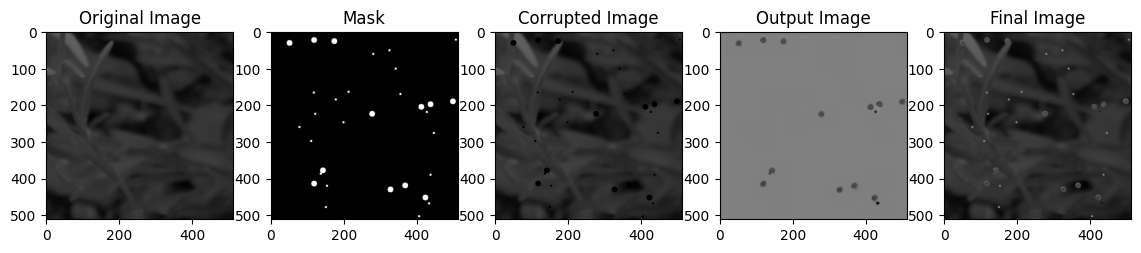

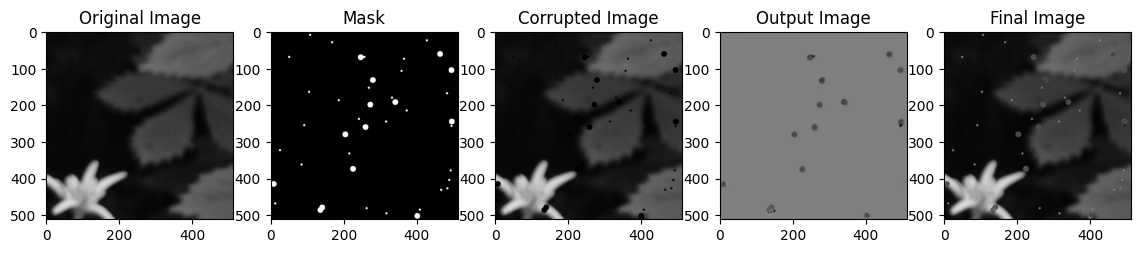

In [21]:
for original, mask in val_loader:
    original = original.to(device)
    mask = mask.to(device)
    corrupted = original * (1 - mask) 
    model.eval()
    with torch.no_grad():
        output = model(corrupted, mask)
    final = output * mask + original * (1 - mask)


    print("maximum values: ", torch.max(original).item(), torch.max(mask).item(), torch.max(corrupted).item(), torch.max(output), torch.max(final))
    # plot output 
    fig, axs = plt.subplots(1, 5, figsize=(14, 5))
    axs[0].imshow(original[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask[0].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Mask')
    axs[2].imshow(corrupted[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[2].set_title('Corrupted Image')
    axs[3].imshow(output[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[3].set_title('Output Image')
    #final
    axs[4].imshow(final[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[4].set_title('Final Image')
    # save the figure
    
    



In [22]:
torch.save(model.state_dict(), 'luc.pth')